In [332]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.pipeline import make_pipeline

from ucimlrepo import fetch_ucirepo



In [333]:
pd.set_option('display.max_columns', None)

# Loading and Preprocessing Data

In [334]:
# Fetch Single Elder Home Monitoring dataset
try: 
    single_elder_home_monitoring_gas_and_position = fetch_ucirepo(id=799) 
except Exception as e: 
    print(f'Error fetching Single Elder Home Monitioring dataset: {e}')

# Single Elder data (as pandas dataframe)
single_elder = single_elder_home_monitoring_gas_and_position.data.features

# Load CASAS data to match Susnea et al, as pandas dataframe. 
try:
    hh126 = pd.read_csv('hh126.csv', names = ['original'])
except Exception as e: 
    print(f'Error reading hh216.csv: {e}')

# Load annotated CASAS data from the same house as Susnea et al, as pandas dataframe 
try: 
    casas_lab = pd.read_csv('hh126annotated.csv', names = ['date', 'time', 'room', 'status', 'annotation'])
except Exception as e: 
    print(f'Error reading hh216annotated.csv: {e}')


Single Elder Preprocessing

In [335]:
# converts timestam to datetime format
single_elder['timestamp'] = pd.to_datetime(single_elder['timestamp'])

CASAS Preprocessing, both datasets

In [336]:
# Creates usable columns for CASAS dataset
try: 
    hh126[['date', 'time', 'room', 'status']] = hh126['original'].str.split(' ', expand=True)
    casas = hh126.drop(columns='original')
except Exception as e: 
    print(f'Error creating columns for CASAS dataset: {e}')

# Creates useable datetime column for CASAS datasets
try: 
    casas['datetime'] = casas['date'] + ' ' + casas['time']
    casas['datetime'] = pd.to_datetime(casas['datetime'], format = 'ISO8601')
except Exception as e: 
    print(f'Error making datetime column for CASAS dataset: {e}')

try:
    casas_lab['datetime'] = casas_lab['date'] + ' ' + casas_lab['time']
    casas_lab['datetime'] = pd.to_datetime(casas_lab['datetime'], format = 'ISO8601')
except Exception as e: 
    print(f'Error making datetime column for CASAS annotated dataset: {e}')
    
# establish numerical value columns for CASAS rooms, statuses
try: 
    to_replace = {'Bathroom':1, 'Bedroom':2, 'Kitchen':3, 'LivingRoom':4, 'OutsideDoor':5, 'WorkArea':6}
    casas['room_no'] = casas['room'].replace(to_replace)
    casas_lab['room_no'] = casas['room'].replace(to_replace)
except Exception as e: 
    print(f'Error creating room number column: {e}')

try:
    to_replace = {'ON': 1, 'OFF':2, 'OPEN':3, 'CLOSE':4}
    casas['status_no'] = casas['status'].replace(to_replace)
    casas_lab['status_no'] = casas_lab['status'].replace(to_replace)
except Exception as e: 
    print(f'Error creating room status column: {e}')

# create an hour column for broader initial consideration of activities
try: 
    casas['hour'] = casas['datetime'].dt.hour
    casas_lab['hour'] = casas['datetime'].dt.hour
except Exception as e: 
    print(f'Error creating hour column: {e}')


CASAS Preprocessing, unique to annotated dataset

In [337]:
# Unifies formatting for activites, removes "begin" and "end" markers, assumption is made that all activities begin with the first occurance of the notation and end at the last one in a time series. 
to_replace = {'Sleep="begin"': 'Sleep', 'Sleep="end"': 'Sleep', 
              'Personal_Hygiene="begin"':'Personal Hygiene', 'Personal_Hygiene="end"': 'Personal Hygiene', 'Personal_Hygiene': 'Personal Hygiene',
              'Dress="begin"': 'Dress', 'Dress="end"' : 'Dress', 
              'Toilet="begin"': 'Toilet', 'Toilet="end"': 'Toilet', 
              'Cook_Breakfast="begin"': 'Cook Breakfast', 'Cook_Breakfast="end"': 'Cook Breakfast', 'Cook_Breakfast': 'Cook Breakfast',
              'Morning_Meds="begin"': 'Morning Meds', 'Morning_Meds="end"': 'Morning Meds', 'Morning_Meds': 'Morning Meds',
              'Eat_Breakfast="begin"': 'Eat Breakfast', 'Eat_Breakfast="end"': 'Eat Breakfast', 'Eat_Breakfast': 'Eat Breakfast',
              'Wash_Breakfast_Dishes="begin"': 'Wash Breakfast Dishes', 'Wash_Breakfast_Dishes="end"': 'Wash Breakfast Dishes', 'Wash_Breakfast_Dishes': 'Wash Breakfast Dishes',
              'Work_On_Computer="begin"': 'Work on Computer', 'Work_On_Computer="end"': 'Work on Computer', 'Work_On_Computer': 'Work on Computer',
              'Groom="begin"': 'Groom', 'Groom="end"': 'Groom',
              'Step_Out': 'Visit Yard','Step_Out="begin"': 'Visit Yard', 'Step_Out="end"': 'Visit Yard',
              'Phone="begin"': 'Phone', 'Phone="end"': 'Phone',
              'Leave_Home="begin"': 'Leave Home', 'Leave_Home="end"': 'Leave Home', 'Leave_Home': 'Leave Home',
              'Enter_Home': 'Enter Home', 'Enter_Home="begin"': 'Enter Home','Enter_Home="end"': 'Enter Home', 
              'Read="begin"': 'Read', 'Read="end"': 'Read',
              'Drink="begin"': 'Drink', 'Drink="end"': 'Drink',
              'Cook_Lunch="begin"': 'Cook Lunch', 'Cook_Lunch="end"':'Cook Lunch', 'Cook_Lunch': 'Cook Lunch',
              'Eat_Lunch="begin"': 'Eat Lunch', 'Eat_Lunch="end"': 'Eat Lunch', 'Eat_Lunch': 'Eat Lunch',
              'Watch_TV="begin"': 'Watch TV', 'Watch_TV="end"': 'Watch TV', 'Watch_TV': 'Watch TV',
              'Evening_Meds="begin"': 'Evening Meds', 'Evening_Meds="end"': 'Evening Meds', 'Evening_Meds': 'Evening Meds', 
              'Bed_Toilet_Transition="begin"': 'Bed Toilet Transition', 'Bed_Toilet_Transition="end"': 'Bed Toilet Transition', 'Bed_Toilet_Transition':'Bed Toilet Transition',
              'Wash_Dishes="begin"': 'Wash Dishes', 'Wash_Dishes="end"': 'Wash Dishes', 'Wash_Dishes': 'Wash Dishes', 
              'Cook_Dinner="begin"': 'Cook Dinner', 'Cook_Dinner="end"': 'Cook Dinner', 'Cook_Dinner': 'Cook Dinner',
              'Eat_Dinner="begin"': 'Eat Dinner', 'Eat_Dinner="end"': 'Eat Dinner', 'Eat_Dinner': 'Eat Dinner',
              'Wash_Lunch_Dishes="begin"': 'Wash Lunch Dishes', 'Wash_Lunch_Dishes="end"': 'Wash Lunch Dishes', 'Wash_Lunch_Dishes': 'Wash Lunch Dishes',
              'Entertain_Guests="begin"': 'Entertain Guests', 'Entertain_Guests="end"': 'Entertain Guests',
              'Bathe="begin"': 'Bathe', 'Bathe="end"':'Bathe',
              'Sleep_Out_Of_Bed="begin"': 'Sleep Out Of Bed', 'Sleep_Out_Of_Bed="end"':'Sleep Out Of Bed', 'Sleep_Out_Of_Bed': 'Sleep Out of Bed',
              'Wash_Dinner_Dishes': 'Wash Dinner Dishes', 'Wash_Dinner_Dishes="begin"': 'Wash Dinner Dishes', 'Wash_Dinner_Dishes="end"': 'Wash Dinner Dishes', 
              'Relax="begin"': 'Relax', 'Relax="end"': 'Relax',
              'Cook="begin"':'Cook', 'Cook="end"': 'Cook', 
              'Eat="begin"': 'Eat', 'Eat="end"': 'Eat'
              }
casas_lab['activity'] = casas_lab['annotation'].replace(to_replace)

In [ ]:
# fills all null activity values with the previous one, on the assumption that no activity changes until a new notation is made
casas_lab['activity']=casas_lab['activity'].ffill()

Preprocessing for all three datasets:

In [ ]:
single_elder['week day'] = single_elder['timestamp'].dt.day_of_week
casas['week day'] = casas['datetime'].dt.day_of_week
casas_lab['week day'] = casas_lab['datetime'].dt.day_of_week

# Initial Data Explorations

In [ ]:
# Combined IDE function
def IDE(df):
    print(f'Shape of features: \n {df.shape}\n')
    print(f'\nDescription of features: \n {df.describe()}\n\nFeature information:')
    print(f'{df.info()}\n')
    print(f'\nNull values of features: \n {df.isnull().sum()}\n')
    print(f'\nFirst 5 rows of features: \n {df.head(5)}')


## Single Elder Home Monitoring Gas and Position

In [ ]:
# metadata and variable descriptions
print(f'Metadata: \n {single_elder_home_monitoring_gas_and_position.metadata}\n\nFeature information: \n{single_elder_home_monitoring_gas_and_position.variables}')


Metadata: 
 {'uci_id': 799, 'name': 'Single Elder Home Monitoring: Gas and Position', 'repository_url': 'https://archive.ics.uci.edu/dataset/799/single+elder+home+monitoring+gas+and+position', 'data_url': 'https://archive.ics.uci.edu/static/public/799/data.csv', 'abstract': 'This dataset contains gas and temperature sensors as well as movement infra-red sensors from the monitoring of an elder person living alone in their own home from 2019-11-06 to 2020-02-13. The measurings have a temporal resolution of 20 seconds. The air and gas sensors measure temperature, humidity, CO2, CO and MOX readings. The data from the position sensors are binary; for each room, a 1 means that movement has been detected in that room while a 0 means that the sensor has gone back to baseline. The attached figure represents a simple layout of the monitored home as well as the sensors locations. The dataset also includes 19 days of measurements (from 2020-01-25 to 2020-02-13) where noone was occupying the room (

In [ ]:
IDE(single_elder)

Shape of features: 
 (416153, 11)


Description of features: 
          temperature       humidity  CO2CosIRValue  CO2MG811Value  \
count  416153.000000  416153.000000  416153.000000  416153.000000   
mean       20.115751      52.236446     102.459415     539.086523   
std         2.295836       4.343208      39.026812      34.934361   
min        13.530000      38.160000      21.000000     408.000000   
25%        18.640000      49.050000      76.000000     510.000000   
50%        20.100000      52.310000     105.000000     528.000000   
75%        21.630000      55.640000     117.000000     563.000000   
max        26.140000      69.260000     591.000000     632.000000   

                MOX1           MOX2           MOX3           MOX4  \
count  416153.000000  416153.000000  416153.000000  416153.000000   
mean      500.289413     718.708761     672.788842     609.446752   
std        49.795030      31.296907      36.354293      42.703923   
min       262.000000     514.000000    

Jamie, I deleted setting the index to the timestamp, because the other dataset has timestamp data we may want to use too, and it might be helpful for classifying, but we can't use it like that unless it's not an index. We can always change that later. 

I also removed the website, since I added a citations textbox at the bottom. 

### Single Elder variables, graphically

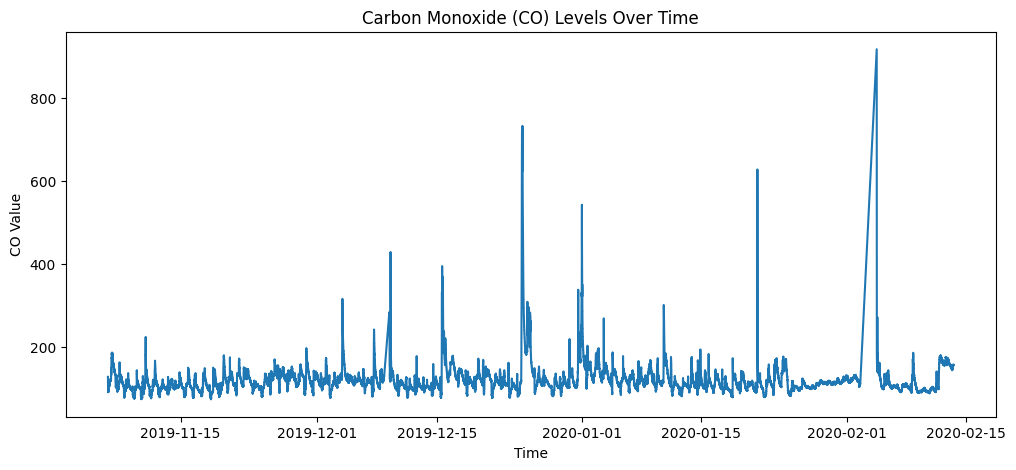

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(single_elder['timestamp'], single_elder['COValue'])
plt.title("Carbon Monoxide (CO) Levels Over Time")
plt.xlabel("Time")
plt.ylabel("CO Value")
plt.show()

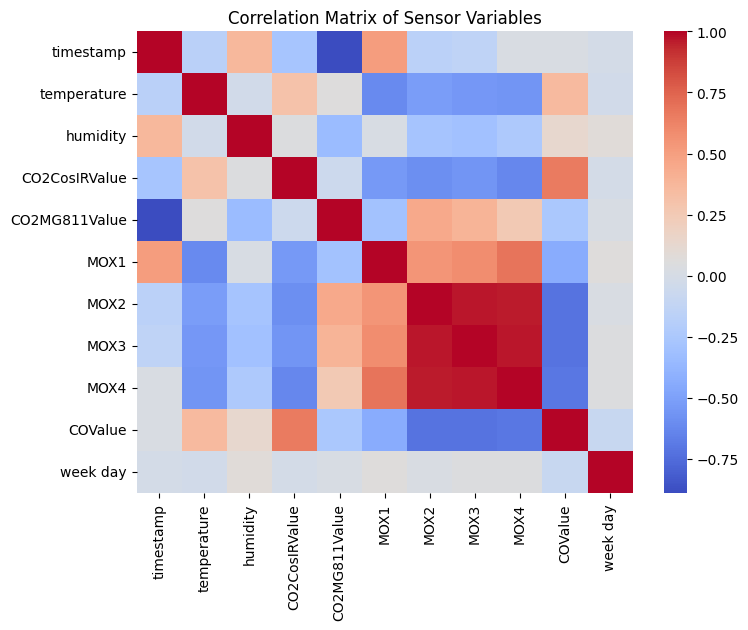

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(single_elder.corr(), annot=False, cmap="coolwarm")
plt.title("Correlation Matrix of Sensor Variables")
plt.show()

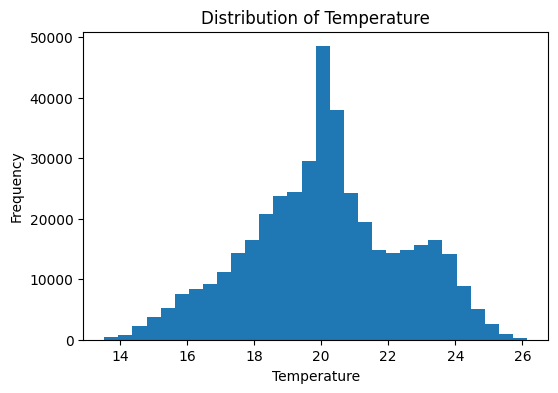

In [ ]:
plt.figure(figsize=(6,4))
plt.hist(single_elder['temperature'], bins=30)
plt.title("Distribution of Temperature")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.show()

## CASAS HH126 with annotations of activities

In [ ]:
IDE(casas_lab)

Shape of features: 
 (111801, 11)


Description of features: 
                          datetime           hour       week day
count                      111801  111801.000000  111801.000000
mean   2013-08-18 14:37:11.833317      12.624467       3.009696
min    2013-08-01 00:32:08.190804       0.000000       0.000000
25%    2013-08-08 19:40:44.092738       8.000000       1.000000
50%    2013-08-18 08:34:46.638255      12.000000       3.000000
75%    2013-08-27 19:12:49.903112      17.000000       5.000000
max    2013-09-06 12:51:51.643948      23.000000       6.000000
std                           NaN       4.950275       1.948816

Feature information:
<class 'pandas.DataFrame'>
RangeIndex: 111801 entries, 0 to 111800
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   date        111801 non-null  str           
 1   time        111801 non-null  str           
 2   room        111801 non-null  str      

<function matplotlib.pyplot.show(close=None, block=None)>

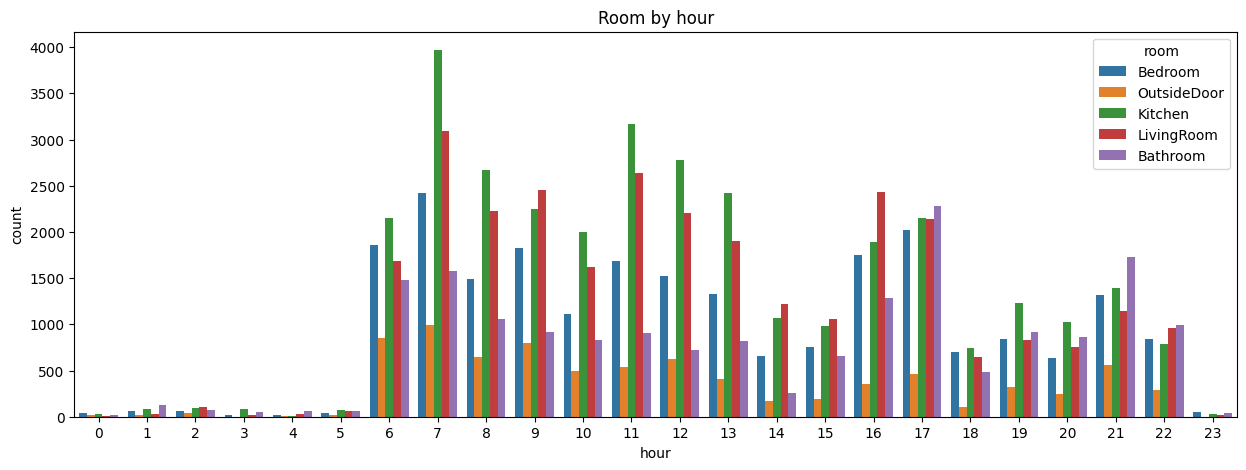

In [ ]:
plt.figure(figsize=(15,5))
sns.countplot(x=casas_lab['hour'], hue=casas_lab['room'], )
plt.title('Room by hour')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

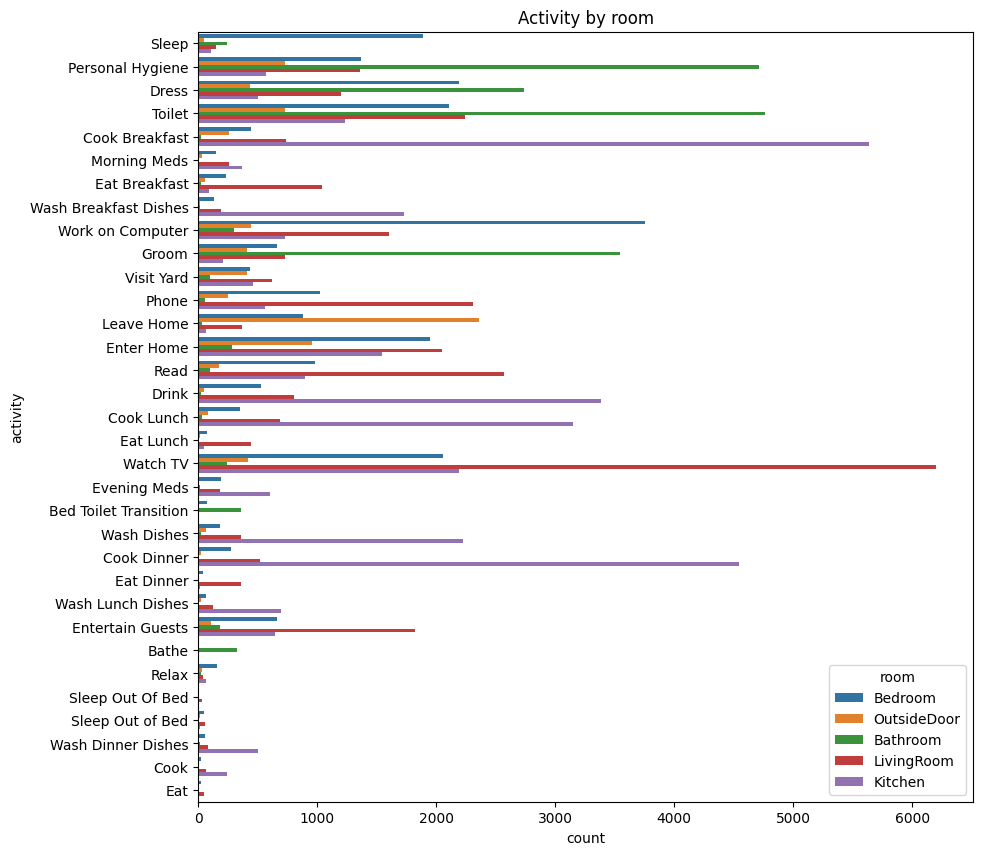

In [345]:
plt.figure(figsize = (10, 10))
sns.countplot(y = casas_lab['activity'], hue=casas_lab['room'])
plt.title('Activity by room')
plt.show

## CASAS HH126 without annotations

In [ ]:
IDE(casas)

Shape of features: 
 (3317283, 9)


Description of features: 
                          datetime          hour      week day
count                     3317283  3.317283e+06  3.317283e+06
mean   2015-08-25 07:47:30.579351  1.274210e+01  3.065341e+00
min    2013-08-01 00:32:08.190804  0.000000e+00  0.000000e+00
25%    2014-08-03 12:35:10.938775  8.000000e+00  1.000000e+00
50%    2015-11-01 05:51:09.891231  1.200000e+01  3.000000e+00
75%    2016-07-05 14:03:24.738220  1.700000e+01  5.000000e+00
max    2017-05-10 12:54:31.118900  2.300000e+01  6.000000e+00
std                           NaN  4.896587e+00  2.000613e+00

Feature information:
<class 'pandas.DataFrame'>
RangeIndex: 3317283 entries, 0 to 3317282
Data columns (total 9 columns):
 #   Column     Dtype         
---  ------     -----         
 0   date       str           
 1   time       str           
 2   room       str           
 3   status     str           
 4   datetime   datetime64[us]
 5   room_no    object        
 6   sta

<function matplotlib.pyplot.show(close=None, block=None)>

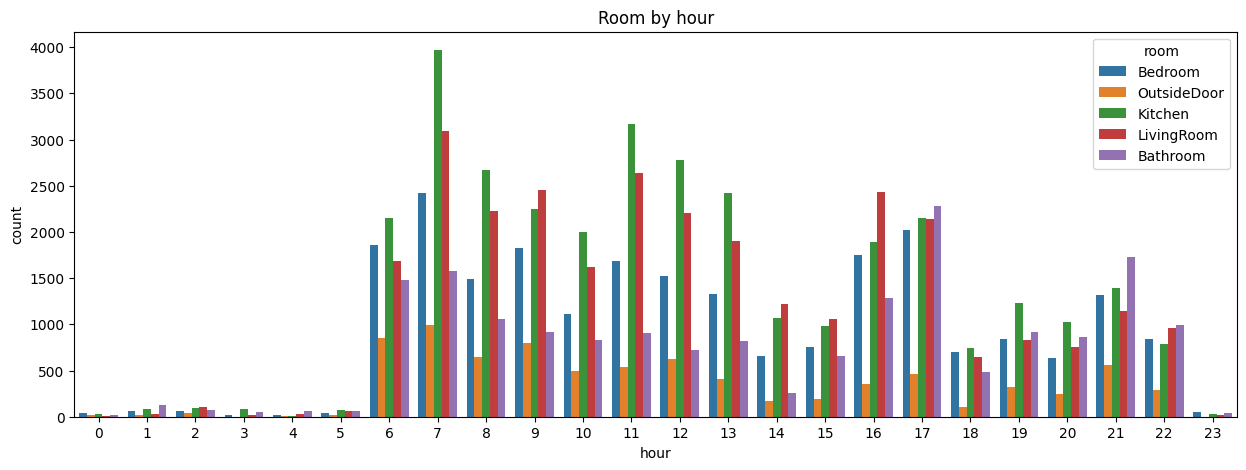

In [ ]:
plt.figure(figsize=(15,5))
sns.countplot(x=casas_lab['hour'], hue=casas_lab['room'], )
plt.title('Room by hour')
plt.show

# Initial Classification Exploration: 

In [374]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.pipeline import make_pipeline


In [375]:
def test_pipeline(pipeline, X, y): 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 1, stratify=y)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_true=y_test, y_pred= y_pred)
    print(f'Scores: \n Accuracy: {accuracy_score(y_true=y_test, y_pred= y_pred)}')

    confus_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
    print(f'\nConfusion Matrix:\n', confus_matrix)

In [376]:
pipe_knn = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=5))
pipe_SVM = make_pipeline(StandardScaler(), SVC(kernel='rbf', random_state=1, gamma=0.10, C=10.0))
pipe_log_regression = make_pipeline(StandardScaler(), LogisticRegression(random_state=1, solver='lbfgs'))

In [377]:
# Sets X and y definitions for labeled CASAS data
casas_lab_X = casas_lab[['room_no', 'status_no', 'hour']]
casas_lab_y = casas_lab['activity']

In [378]:
test_pipeline(pipe_KNN, casas_lab_X, casas_lab_y)

Scores: 
 Accuracy: 0.10837482484123909

Confusion Matrix:
 [[  9   2   0 ...   0  11   0]
 [  2   0   0 ...   0  17   0]
 [  0   3   9 ...   0   0  24]
 ...
 [  0   0   0 ...   0  77   5]
 [ 38  19   2 ...   0 659  78]
 [  6  10  38 ...   0 227 112]]


In [379]:
test_pipeline(pipe_log_regression, casas_lab_X, casas_lab_y)

Scores: 
 Accuracy: 0.12489192331773054

Confusion Matrix:
 [[   0    0    0 ...    0   84    0]
 [   0    0    0 ...    0  119    0]
 [   0    0    0 ...    0   14    0]
 ...
 [   0    0    0 ...    0   43    0]
 [   0    0    0 ...    0 1938    0]
 [   0    0    0 ...    0  650    0]]


In [380]:
test_pipeline(pipe_SVM, casas_lab_X, casas_lab_y)

Scores: 
 Accuracy: 0.1493694284606899

Confusion Matrix:
 [[   0    0    0 ...    0   30    0]
 [   0    0    0 ...    0   85    0]
 [   0    0    0 ...    0    0    0]
 ...
 [   0    0    0 ...    0   43    0]
 [   0    0    0 ...    0 1864    0]
 [   0    0    0 ...    0  474    0]]


In [381]:
pipe_knn = make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=5))
pipe_SVM = make_pipeline(StandardScaler(), SVC(kernel='rbf', random_state=44, gamma=0.10, C=10.0))
pipe_log_regression = make_pipeline(StandardScaler(), LogisticRegression(random_state=44, solver='lbfgs'))

In [382]:
to_replace = {'Bathroom':1, 'Bedroom':2, 'Kitchen':3, 'LivingRoom':4, 'OutsideDoor':5, 'WorkArea':6}
to_replace = {'ON': 1, 'OFF':2, 'OPEN':3, 'CLOSE':4}

# Bibliography
Cook, D. (2025). CASAS Smart Home dataset—Free living, motion, door, activity labels [Dataset]. Zenodo. https://doi.org/10.5281/ZENODO.15708567

Marín, D., Joshua Llano-Viles, Zouhair Haddi, Alexandre Perera-Lluna, & Jordi Fonollosa. (2023). Home monitoring for older singles: A gas sensor array system. Sensors and Actuators B: Chemical, 393, 134036. https://doi.org/10.1016/j.snb.2023.134036
